In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.ar_model import AutoReg

In [3]:
tempelhof=pd.read_csv('TG_STAID002759.txt', skiprows=20, names=['SOUID', 'DATE', 'temp', 'Q_TG'], 
                 dtype={'SOUID':'int64', 'temp':'int64','Q_TG':'int64'})
tempelhof=tempelhof.set_index(pd.to_datetime(tempelhof.DATE, format='%Y%m%d', errors='ignore')).drop('DATE', axis=1)
tempelhof=tempelhof['2010':].drop('Q_TG', axis=1)
tempelhof['month_name']=tempelhof.index.month_name()
tempelhof['month']=tempelhof.index.month
tempelhof['year']=tempelhof.index.year

**Unit of temperature in raw data is 0.1 C, so must convert**

In [4]:
tempelhof['temp']=tempelhof['temp']/10

In [5]:
tempelhof.head()

,SOUID,temp,month_name,month,year
DATE,,,,,
2010-01-01,111448,-1.4,January,1,2010
2010-01-02,111448,-1.7,January,1,2010
2010-01-03,111448,-4.3,January,1,2010
2010-01-04,111448,-5.6,January,1,2010
2010-01-05,111448,-6.0,January,1,2010


### Stationarize Data

In [6]:
tempelhof['diff']=tempelhof['temp'].diff()

In [7]:
tempelhof['monthly_mean']=tempelhof.groupby('month')['diff'].transform('mean')
tempelhof['deseason']=tempelhof['diff']-tempelhof['monthly_mean']

In [8]:
tempelhof.fillna(method='bfill', inplace=True)

In [9]:
tempelhof.head()

,SOUID,temp,month_name,month,year,diff,monthly_mean,deseason
DATE,,,,,,,,
2010-01-01,111448,-1.4,January,1,2010,-0.3,-0.081471,-0.218529
2010-01-02,111448,-1.7,January,1,2010,-0.3,-0.081471,-0.218529
2010-01-03,111448,-4.3,January,1,2010,-2.6,-0.081471,-2.518529
2010-01-04,111448,-5.6,January,1,2010,-1.3,-0.081471,-1.218529
2010-01-05,111448,-6.0,January,1,2010,-0.4,-0.081471,-0.318529


### Examine autocorrelation

In [10]:
for i in range(1,8):
    tempelhof[f'{i}shift_season']=tempelhof['deseason'].shift(i)
tempelhof.fillna(method='bfill', inplace=True)    

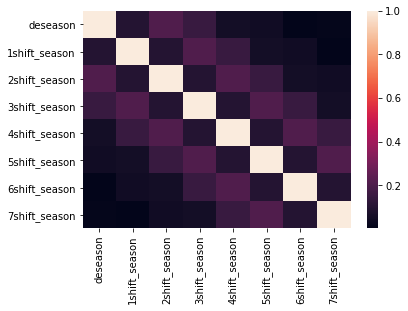

In [11]:
sns.heatmap(tempelhof.drop([x for x in tempelhof.columns if 'season' not in x], axis=1).corr().abs())

In [12]:
pd.DataFrame(tempelhof.drop([x for x in tempelhof.columns if 'season' not in x], axis=1).corr().loc['deseason'])

,deseason
deseason,1.000000
1shift_season,0.097404
2shift_season,-0.211846
3shift_season,-0.153785
4shift_season,-0.055255
5shift_season,-0.048966
6shift_season,-0.002525
7shift_season,-0.013946


**shift days 2 and 3 show the largest correlation with the non-shifted data, use this for modeling**

### Split and Train model 

In [13]:
xtrain=tempelhof[['2shift_season', '3shift_season']][:'2019-04-29']
xtest=tempelhof[['2shift_season', '3shift_season']]['2019-04-30':]
ytrain=tempelhof['deseason'][:'2019-04-29']
ytest=tempelhof['deseason']['2019-04-30':]

In [14]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((3406, 2), (367, 2), (3406,), (367,))

In [15]:
m=LinearRegression()
m.fit(xtrain, ytrain)
ypred=m.predict(xtest)

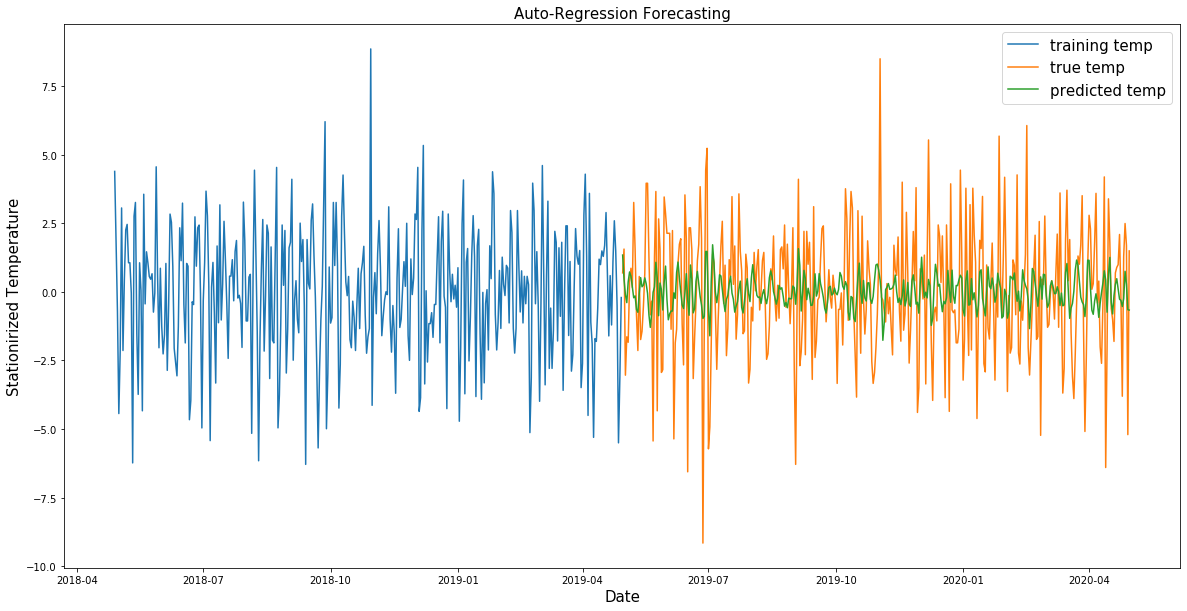

In [16]:
plt.figure(figsize=(20,10))
plt.plot(xtrain[-367:].index, ytrain[-367:], label='training temp')
plt.plot(xtest.index, ytest, label='true temp')
plt.plot(xtest.index, ypred, label='predicted temp')
plt.title('Auto-Regression Forecasting', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Stationirized Temperature', fontsize=15)
plt.legend(fontsize=15)

### Evaluate model 

In [17]:
# method 1
xtrain['w0']=1
m2=OLS(ytrain, xtrain).fit()
print(f'model RMSE: {np.sqrt(mean_squared_log_error(np.absolute(ytest), np.absolute(ypred)))}')
print(f'model AIC: {m2.aic}')

model RMSE: 0.7746609427963694
model AIC: 15043.131031651163


In [18]:
# method 2
m=AutoReg(ytrain, lags=[2,3])
res=m.fit()
print(res.summary())

/Users/gdquiceno2/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                            AutoReg Model Results                             
Dep. Variable:               deseason   No. Observations:                 3406
Model:              Restr. AutoReg(3)   Log Likelihood               -7512.733
Method:               Conditional MLE   S.D. of innovations              2.201
Date:                Sun, 30 Aug 2020   AIC                              1.580
Time:                        20:27:05   BIC                              1.587
Sample:                    01-04-2010   HQIC                             1.582
                         - 04-29-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       0.0004      0.038      0.010      0.992      -0.074       0.074
deseason.L2    -0.1899      0.017    -11.367      0.000      -0.223      -0.157
deseason.L3    -0.1369      0.017     -8.189    

### Reconstruct Predicted Data

In [19]:
ypred_reconstructed=pd.DataFrame(ypred, columns=['predicted'], index=xtest.index)

In [20]:
ypred_reconstructed['reseason']=ypred_reconstructed['predicted']+tempelhof['monthly_mean'][-367:]
ypred_reconstructed.loc[ypred_reconstructed.index[0],'reseason']=tempelhof.loc['2019-04-30','temp']
ypred_reconstructed['retrend']=np.cumsum(ypred_reconstructed['reseason'])

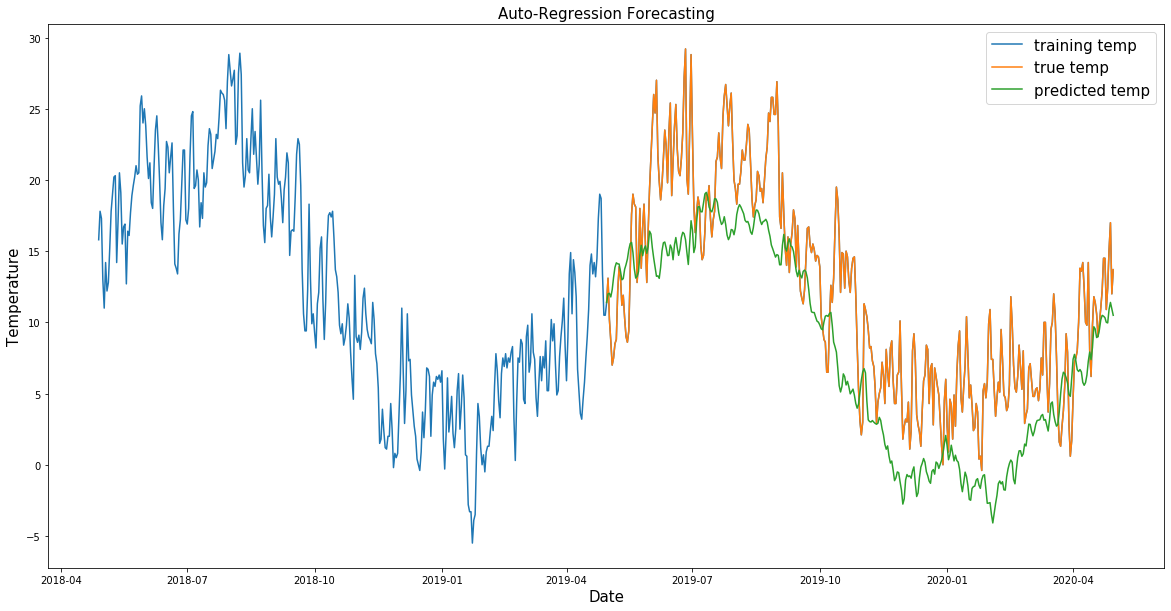

In [21]:
plt.figure(figsize=(20,10))
plt.plot(tempelhof[-734:].index, tempelhof.temp[-734:], label='training temp')
plt.plot(xtest.index, tempelhof.temp[-367:], label='true temp')
plt.plot(xtest.index, ypred_reconstructed.retrend, label='predicted temp')
plt.title('Auto-Regression Forecasting', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.legend(fontsize=15)
plt.savefig('AR_forecast')